# Image blurring

This notebook is about showing how different box blurring techniques look like on images.

Initial idea to create this notebook is because common blurring techniques deliver sharp edges when an image area is blurred. But the desired result is a blurred area with soft edges, which looks more natural.

This notebook will show the result of each blurring technique and the results can be compared while walking through the steps.

## Application and libraries

Application was written in **Python 3.11** and uses some libraries:
- [**OpenCV**](https://opencv.org) - a computer vision library
- [**NumPy**](https://numpy.org) - to handle large arrays and matrices
- [**Matplotlib**](https://matplotlib.org) - a library for visualization in Python
- [**Pillow**](https://python-pillow.github.io) - Python Imaging Library

To begin with, we import all those libraries to our code:

In [256]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw, ImageFont, ImageOps

## Use case

Simple workflow is:
- load the image
- define blurring areas (boxes)
- blur those areas and show the result

To begin with, let's define a data class for the blurring areas, called `Box`.

`Box` represents a rectangle with 4 attributes: `xmin` (x1), `xmax` (x2), `ymin` (y1), `ymax` (y2).

Width and height are properties automatically calculated.

In [259]:
from dataclasses import dataclass

@dataclass
class Box:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def width(self) -> int:
        return self.xmax - self.xmin

    @property
    def height(self) -> int:
        return self.ymax - self.ymin

    @property
    def shape(self) -> tuple[int, int, int, int]:
        return (self.xmin, self.ymin, self.xmax, self.ymax)

    def kernel(self, factor: int = 2) -> tuple[int, int]:
        return tuple(int(n / 10) * factor + 1 for n in (self.width, self.height))

    def mask(self) -> np.array:
        border = int(max(width, height) * .03)
        mask_img = Image.new('RGBa', (self.width, self.height), color=(0xff, 0xff, 0xff, 0))

        draw = ImageDraw.Draw(mask_img)
        draw.rectangle((border, border, self.width - border, self.height - border), fill=(0, 0, 0, 0xff))

        def calc_linear_kernel(width: int, height: int, factor: int = 2) -> tuple[int, int]:
            m = max(width, height)
            return tuple(int(n / 10) * factor + 1 for n in (m, m))

        blurred_mask = cv2.GaussianBlur(np.array(mask_img), calc_linear_kernel(self.width, self.height), 0)
        return ImageOps.invert(Image.fromarray(blurred_mask))

## Image loading

Here the areas (boxes) that should be blurred are defined using the class `Box`.

Image is loaded and shown twice: one plain, other showing the areas that should be blurred.

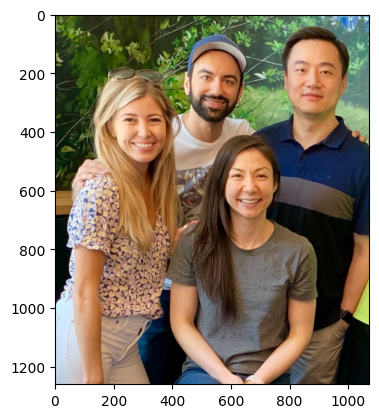

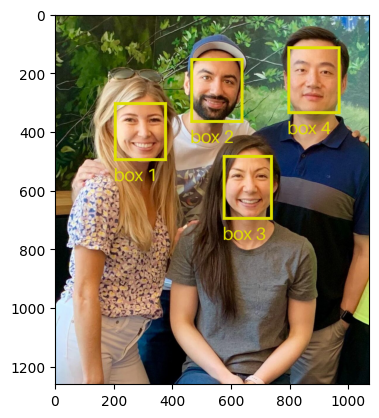

In [222]:
IMG_PATH = 'image.jpg'

BLUR_BOXES = [
    # from left to right...
    Box(200, 300, 380, 500), # first woman's face
    Box(460, 150, 640, 370), # first man's face
    Box(570, 480, 740, 700), # second woman's face
    Box(790, 110, 970, 340), # second man's face
]

img_pil = Image.open(IMG_PATH)

plt.imshow(img_pil)
plt.show()

# draw boxes on a copy of the image

img_pil_copy = img_pil.copy()
draw = ImageDraw.Draw(img_pil_copy)
color = (0xdf, 0xdf, 0)
font = ImageFont.load_default(size=60)

for idx, box in enumerate(BLUR_BOXES, start=1):
    draw.text((box.xmin, box.ymax + 10), f'box {idx}', color, font=font)
    draw.rectangle(box.shape, outline=color, width=10)

plt.imshow(img_pil_copy)
plt.show()

## Common blur

This function will demonstrate what the common blur delivers as a result.

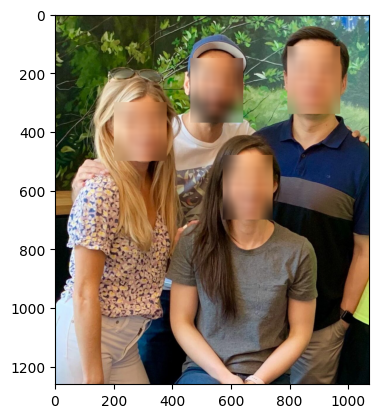

In [232]:
def blur(image: np.ndarray, boxes: list[Box]) -> np.ndarray:
    out_image = image.copy()
    for box in boxes:
        kernel = tuple(int(n / 10) * 3 + 1 for n in (box.width, box.height))
        out_image[box.ymin:box.ymax, box.xmin:box.xmax] = cv2.blur(out_image[box.ymin:box.ymax, box.xmin:box.xmax], kernel)
    return out_image


img = np.array(img_pil)

plt.imshow(blur(img, BLUR_BOXES))
plt.show()

## Gaussian blur

This function will demonstrate what the Gaussian blur delivers as a result.

Notice that the blurring area is softer compared to the commun blur.

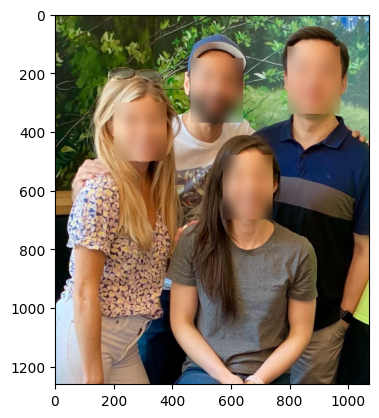

In [238]:
def gaussian_blur(image: np.ndarray, boxes: list[Box]) -> np.ndarray:
    border = 20
    out_image = image.copy()
    for box in boxes:
        kernel = tuple(int(n / 10) * 6 + 1 for n in (box.width, box.height))
        crop = out_image[box.ymin:box.ymax, box.xmin:box.xmax]
        out_image[box.ymin:box.ymax, box.xmin:box.xmax] = cv2.GaussianBlur(crop, kernel, 0)
    return out_image


plt.imshow(gaussian_blur(img, BLUR_BOXES))
plt.show()

## Masked gaussian blur

Now let's see what the masked Gaussian blur delivers as a result.

This technique consists in creating a mask representing the box, blur it and use it to soften the edges of the blurred area.

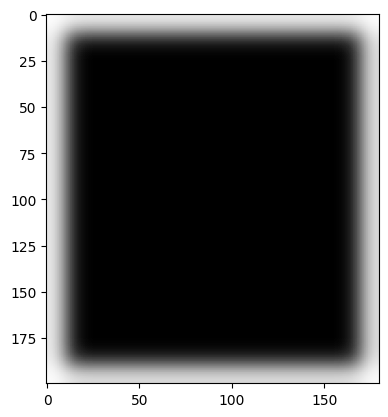

OSError: not supported for mode RGBA

In [260]:
# get the first blur box as an example

box = BLUR_BOXES[0]

plt.imshow(box.mask())
plt.show()

box = Box(0, 0, img_pil.width, img_pil.height)
plt.imshow(box.mask())
plt.show()

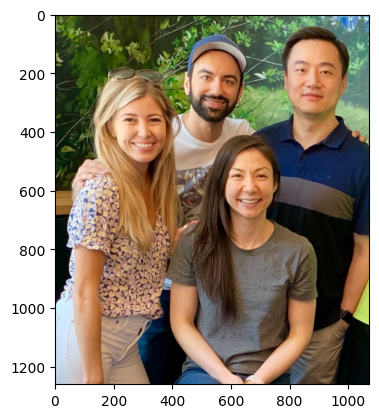

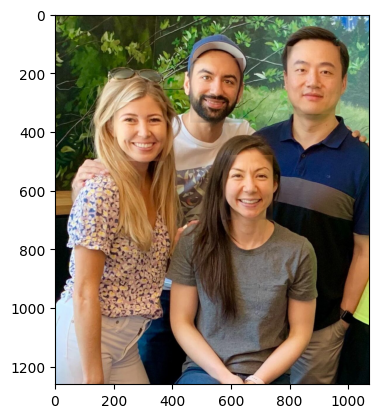

In [247]:
def masked_gaussian_blur(image: np.ndarray, boxes: list[Box]) -> np.ndarray:
    border = 20
    out_image = image.copy()
    for box in boxes:
        kernel = tuple(int(n / 10) * 6 + 1 for n in (box.width, box.height))
        crop = out_image[box.ymin:box.ymax, box.xmin:box.xmax]
        blurred_crop = cv2.GaussianBlur(crop, kernel, 0)

        final_crop = Image.composite(Image.fromarray(crop), Image.fromarray(blurred_crop), Image.fromarray(box.mask()))
        out_image[box.ymin:box.ymax, box.xmin:box.xmax] = np.array(final_crop)
    return out_image


plt.imshow(Image.fromarray(img))
plt.show()

plt.imshow(masked_gaussian_blur(img, BLUR_BOXES))
plt.show()